# get data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -R /content/drive/MyDrive/ecg_data/ ecg_data/

# train supervised model

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tqdm.notebook import tqdm
from IPython.display import clear_output
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold

In [ ]:
data_path = 'ecg_data'

In [ ]:
signals = np.load(os.path.join(data_path, 'signals.npy'))
target = np.load(os.path.join(data_path, 'target.npy'))

In [ ]:
TIME_SECTION = 10

TRX_SIZE = 256
HIDDEN_SIZE = 256
NUM_LAYERS = 2

VAL_SIZE = 0.05
BATCH_SIZE = 64

NUM_EPOCHS = 75

DEVICE = 'cuda' if torch.cuda.is_available else 'cpu'

BEST_MODEL_PATH = 'best_model.pth'

In [ ]:
trx_encoder = nn.Sequential(
          nn.Linear(TIME_SECTION*12, TRX_SIZE)
)

In [ ]:
seq_encoder = torch.nn.LSTM(
    TRX_SIZE,
    HIDDEN_SIZE,
    NUM_LAYERS,
    batch_first=True
)

In [ ]:
class extract_seq_embeddings(nn.Module):
    def forward(self, input):
        outputs, _ = input
        embeddings = torch.stack([x[-1] for x in outputs])
        return embeddings

In [ ]:
model = nn.Sequential(
    trx_encoder,
    seq_encoder,
    extract_seq_embeddings(),
    nn.Linear(HIDDEN_SIZE, 1),
    nn.Sigmoid(),
)

model = model.to(DEVICE)

In [ ]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def train_one_batch(batch, model, criterion, optimizer, train_losses, device):
    optimizer.zero_grad()

    seqs, labels = batch

    outputs = model(seqs.float().to(device))
    outputs = torch.squeeze(outputs, 1)
    loss = criterion(outputs.to(device), labels.to(device))

    loss.backward()
    optimizer.step()
    train_losses.append(loss.item()/len(seqs))
    return train_losses

In [ ]:
def validate_one_batch(batch, model, criterion, val_losses, val_probs, val_labels, device):
    with torch.no_grad():
        seqs, labels = batch

        outputs = model(seqs.float().to(device))
        probs = torch.squeeze(outputs, 1)
        loss = criterion(probs.to(device), labels.to(device))

        val_probs.append(probs)
        val_labels.append(labels)
        val_losses.append(loss.item()/len(seqs))

    return val_losses, val_probs, val_labels

In [ ]:
def train_one_epoch(model, criterion, optimizer, train_dataloader, device):
    model.train()
    train_loss = []
    for batch in tqdm(train_dataloader):
        train_loss = train_one_batch(batch, model, criterion, optimizer, train_loss, device)

    return sum(train_loss) / len(train_dataloader)

def validate_one_epoch(model, criterion, val_metric, val_dataloader, device):
    val_loss = []
    val_probs = []
    val_labels = []

    model.eval()
    for batch in val_dataloader:
        val_loss, val_probs, val_labels = validate_one_batch(batch, model, criterion, val_loss, val_probs, val_labels, device)

    val_probs = torch.hstack(val_probs).cpu().detach().numpy()
    val_labels = torch.hstack(val_labels).cpu().detach().numpy()

    cur_metric = val_metric(val_labels, val_probs)
    return sum(val_loss) / len(val_dataloader), cur_metric

In [ ]:
def train(
    model,
    criterion,
    val_metric,
    optimizer,
    train_dataloader,
    val_dataloader,
    num_epochs,
    device='cuda' if torch.cuda.is_available else 'cpu',
    best_model_path='best_model.pth',
    max_patience=5,
    visualize_training=True,
):

    train_losses = []
    val_losses = []
    val_metrics = []

    max_metric = -np.inf
    cur_patience = 0
    for epoch in range(num_epochs):
        train_loss = train_one_epoch(model, criterion, optimizer, train_dataloader, device)
        val_loss, cur_metric = validate_one_epoch(model, criterion, val_metric, val_dataloader, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_metrics.append(cur_metric)

        if cur_metric >= max_metric:
            max_metric = cur_metric
            torch.save(model.state_dict(), best_model_path)
        else:
            cur_patience += 1

        if visualize_training:
            visualize_training_step(epoch, num_epochs, train_loss, val_loss, cur_metric, train_losses, val_losses, val_metrics)

        if cur_patience >= max_patience:
            print(f'stop training, epoch: {epoch + 1}')
            break

In [ ]:
def visualize_training_step(epoch, num_epochs, train_loss, val_loss, cur_metric, train_losses, val_losses, val_metrics):
    clear_output(wait=True)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}, Val metric: {cur_metric}')

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(val_losses, label='Val Loss', color='orange')
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.title('Validation Loss')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(val_metrics, label='Val metric', color='red')
    plt.xlabel('epoch')
    plt.ylabel('metric')
    plt.title('Validation metric')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
def collate_fn_supervised(batch):
    seqs = torch.stack([torch.from_numpy(item[0]).float() for item in batch])
    seqs = seqs.reshape((len(batch), -1, TIME_SECTION*12))
    labels = torch.tensor([float(item[1]) for item in batch])
    return seqs, labels

In [ ]:
class SupervisedDataset(torch.utils.data.Dataset):
    def __init__(self, signals, target):
        self.data = signals
        self.target = target

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        signal = self.data[idx]
        label = self.target[idx]
        return signal, label

In [ ]:
train_data = SupervisedDataset(X_train, y_train)

test_data = SupervisedDataset(X_test, y_test)

In [ ]:
print(f'train data len = {len(train_data)}, val data len = {len(test_data)}')

train data len = 17469, val data len = 4368


In [ ]:
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn_supervised)
val_dataloader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True,collate_fn=collate_fn_supervised)

Epoch 42/75, Train Loss: 9.407952704608462e-05, Val Loss: 0.009208627089021214, Val metric: 0.9069833227926416


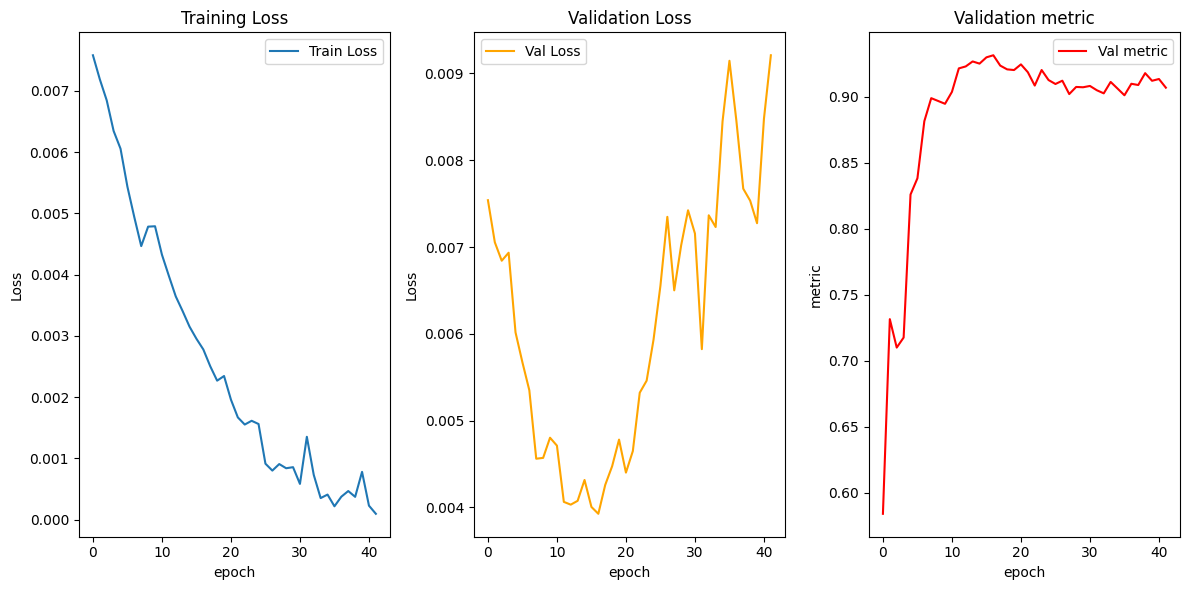

stop training, epoch: 42


In [ ]:
train(model, criterion, roc_auc_score, optimizer, train_dataloader, val_dataloader, NUM_EPOCHS, best_model_path=BEST_MODEL_PATH, max_patience=30)

In [ ]:
def inference_supervised_model(model, inference_dataloader, device, threshold=0.5):
    pred_labels = []
    pred_probs = []
    for batch in tqdm(inference_dataloader):
        seqs, labels = batch

        outputs = model(seqs.float().to(device))
        probs = torch.squeeze(outputs, 1)

        cur_labels = torch.tensor(torch.tensor(probs).clone().detach() > threshold, dtype=int)

        pred_labels.append(cur_labels)
        pred_probs.append(probs)

    pred_labels = torch.hstack(pred_labels).cpu()
    pred_probs = torch.hstack(pred_probs).cpu().detach().numpy()
    return pred_labels, pred_probs

In [ ]:
inference_dataloader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_supervised)

In [ ]:
model.load_state_dict(torch.load(BEST_MODEL_PATH))
model = model.to(DEVICE)

In [ ]:
preds, probs = inference_supervised_model(model, inference_dataloader, DEVICE)

  0%|          | 0/69 [00:00<?, ?it/s]<ipython-input-82-53d00278011b>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cur_labels = torch.tensor(torch.tensor(probs).clone().detach() > threshold, dtype=int)
100%|██████████| 69/69 [00:00<00:00, 109.41it/s]


In [ ]:
accuracy = accuracy_score(preds, [item[1] for item in test_data])
roc_auc = roc_auc_score([item[1] for item in test_data], probs)

print(f'supervised model roc auc score: {roc_auc}')

print(f'supervised model accuracy score: {accuracy}')

supervised model roc auc score: 0.9315351142519317
supervised model accuracy score: 0.9065934065934066


In [ ]:
def init_model():
  trx_encoder = nn.Sequential(
          nn.Linear(TIME_SECTION*12, TRX_SIZE)
        )

  seq_encoder = torch.nn.LSTM(
      TRX_SIZE,
      HIDDEN_SIZE,
      NUM_LAYERS,
      batch_first=True
  )

  model = nn.Sequential(
      trx_encoder,
      seq_encoder,
      extract_seq_embeddings(),
      nn.Linear(HIDDEN_SIZE, 1),
      nn.Sigmoid(),
  )

  model = model.to(DEVICE)
  return model

In [ ]:
def cross_validation(embeddings, target, folds):
    auc_scores = [0 for _ in range(folds.n_splits)]
    accuracy_scores = [0 for _ in range(folds.n_splits)]
    for fold_, (train_index, val_index) in tqdm(enumerate(folds.split(embeddings, target))):

        X_train, y_train = embeddings[train_index], target[train_index]
        # X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train,test_size=0.05, random_state=42)

        train_data = SupervisedDataset(X_train, y_train)
        # val_data = SupervisedDataset(X_val, y_val)

        train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn_supervised)
        # val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn_supervised)


        X_val, y_val = embeddings[val_index], target[val_index]
        val_data = SupervisedDataset(X_val, y_val)
        val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn_supervised)



        model = init_model()
        train(model, criterion, roc_auc_score, optimizer, train_dataloader, val_dataloader, NUM_EPOCHS, best_model_path=BEST_MODEL_PATH, max_patience=30)

        model.load_state_dict(torch.load(BEST_MODEL_PATH))
        model = model.to(DEVICE)

        inference_dataloader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_supervised)

        preds, probs = inference_supervised_model(model, inference_dataloader, DEVICE)


        accuracy = accuracy_score(preds, [item[1] for item in test_data])
        roc_auc = roc_auc_score([item[1] for item in test_data], probs)

        auc_scores[fold_] = roc_auc
        accuracy_scores[fold_] = accuracy
        print(auc_scores)
        print(accuracy_scores)

    print("CV score(auc): {:<8.5f}, (std: {:<8.5f})".format(np.mean(auc_scores), np.std(auc_scores)))
    print("CV score(accuracy): {:<8.5f}, (std: {:<8.5f})".format(np.mean(accuracy_scores), np.std(auc_scores)))
    return (auc_scores, accuracy_scores)

In [ ]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

Epoch 29/75, Train Loss: 0.010671017294591797, Val Loss: 0.01113605412884035, Val metric: 0.5119633504314274


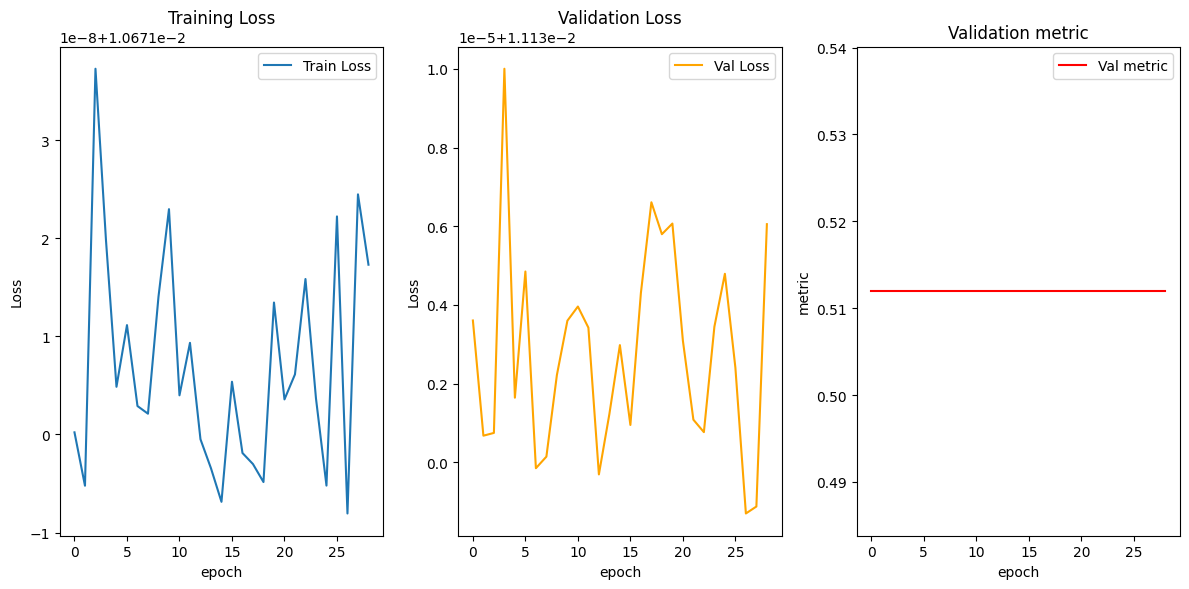

In [ ]:
scores = cross_validation(signals, target, folds)

In [ ]:
print(scores)